In [1]:
import typing
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from paradime.affinity import NeighborBased
from paradime.transforms import PerplexityBased, Symmetrize

In [3]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [4]:
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:500][np.argsort(mnist.targets[:500])]

In [43]:
diss = NeighborBased(90,
    verbose=True,
    # transform=[
    #     PerplexityBased(30, verbose=True),
    #     Symmetrize('tsne')
    # ]
)

In [44]:
foo = diss.compute_affinities(testdata)

2022-06-28 14:32:59.2: Indexing nearest neighbors.


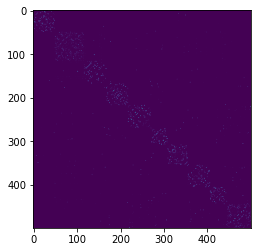

In [23]:
plt.imshow(foo.to_square_array().diss)

In [16]:
def p_i(dists, beta):

    x = - dists**2 * beta
    y = np.exp(x)
    ysum = y.sum()

    return y / ysum

def find_beta(dists, perp, **kwargs):
    return scipy.optimize.root_scalar(
        lambda b: entropy(dists, b) - np.log2(perp),
        **kwargs
    ).root

@jit
def entropy(dists, beta):

    x = dists**2 * beta
    y = np.exp(x)
    ysum = y.sum()

    if ysum < 1e-50:
        result = -1.
    else:
        factor = - 1/(np.log(2.) * ysum)
        result = factor * ((y * x) - (y * np.log(ysum))).sum()
    
    return result

In [34]:
ent = [ entropy(foo.diss[1][58, 1:], b) for b in np.arange(-2., 15., 0.1) ]

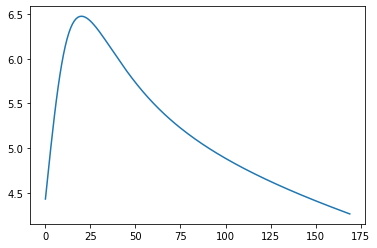

In [35]:
plt.plot(ent)

In [12]:
import openTSNE

In [40]:
otp = openTSNE.affinity.PerplexityBasedNN(testdata, 30)

In [50]:
otp._PerplexityBasedNN__distances.shape

(500, 90)

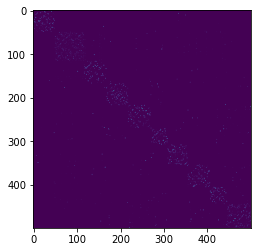

In [59]:
plt.imshow(mine / (mine * 500).sum(axis=1))